In [1]:
library(Signac)
library(Seurat)
library(ggplot2)
library(BSgenome.Mmusculus.UCSC.mm10)

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("EnsDb.Mmusculus.v79")
library(EnsDb.Mmusculus.v79)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: BSgenome

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    sort, table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attac

In [2]:
counts= Read10X_h5('filtered_feature_bc_matrix (1).h5')
fragpath <-"atac_fragments.tsv.gz"

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [3]:
# get gene annotations for hg38
annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)
seqlevels(annotation) <- paste0('chr', seqlevels(annotation))
genome(annotation) <- "mm10"

# create a Seurat object containing the RNA adata
seurat_obj <- CreateSeuratObject(
  counts = counts$`Gene Expression`,
  assay = "RNA"
)

# create ATAC assay and add it to the object
seurat_obj[["ATAC"]] <- CreateChromatinAssay(
  counts = counts$Peaks,
  sep = c(":", "-"),
  fragments = fragpath,
  annotation = annotation
)
seurat_obj

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

An object of class Seurat 
152335 features across 30436 samples within 2 assays 
Active assay: RNA (32285 features, 0 variable features)
 1 layer present: counts
 1 other assay present: ATAC

In [4]:
ref_path = "~/10x_ref/refdata-gex-GRCm39-2024-A/star/geneInfo.tab"
gene_info= read.table(ref_path, skip=1, header=FALSE)
head(gene_info)

,V1,V2,V3
,<chr>,<chr>,<chr>
1,ENSMUSG00000051951,Xkr4,protein_coding
2,ENSMUSG00000089699,Gm1992,lncRNA
3,ENSMUSG00000102331,Gm19938,lncRNA
4,ENSMUSG00000102343,Gm37381,lncRNA
5,ENSMUSG00000025900,Rp1,protein_coding
6,ENSMUSG00000025902,Sox17,protein_coding


In [5]:
e2h= gene_info$V2
names(e2h)= gene_info$V1
h2e= gene_info$V1
names(h2e)= gene_info$V2

In [6]:
E_genes= h2e[rownames(seurat_obj@assays$RNA@features)]
rownames(seurat_obj@assays$RNA@features) = E_genes
str(E_genes)

 Named chr [1:32285] "ENSMUSG00000051951" "ENSMUSG00000089699" ...
 - attr(*, "names")= chr [1:32285] "Xkr4" "Gm1992" "Gm19938" "Gm37381" ...


In [7]:
# H_genes= e2h[rownames(reference@assays$RNA@data)]
# rownames(reference@assays$RNA@data) = H_genes
# rownames(reference@assays$RNA@counts) = H_genes
# rownames(reference@assays$RNA@var.features) = H_genes
# rownames(reference@assays$RNA@scale.data) = H_genes
# str(H_genes)

In [8]:
#QUALITY CONTROL
DefaultAssay(seurat_obj) <- "ATAC"

seurat_obj <- NucleosomeSignal(seurat_obj)
seurat_obj <- TSSEnrichment(seurat_obj)

Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



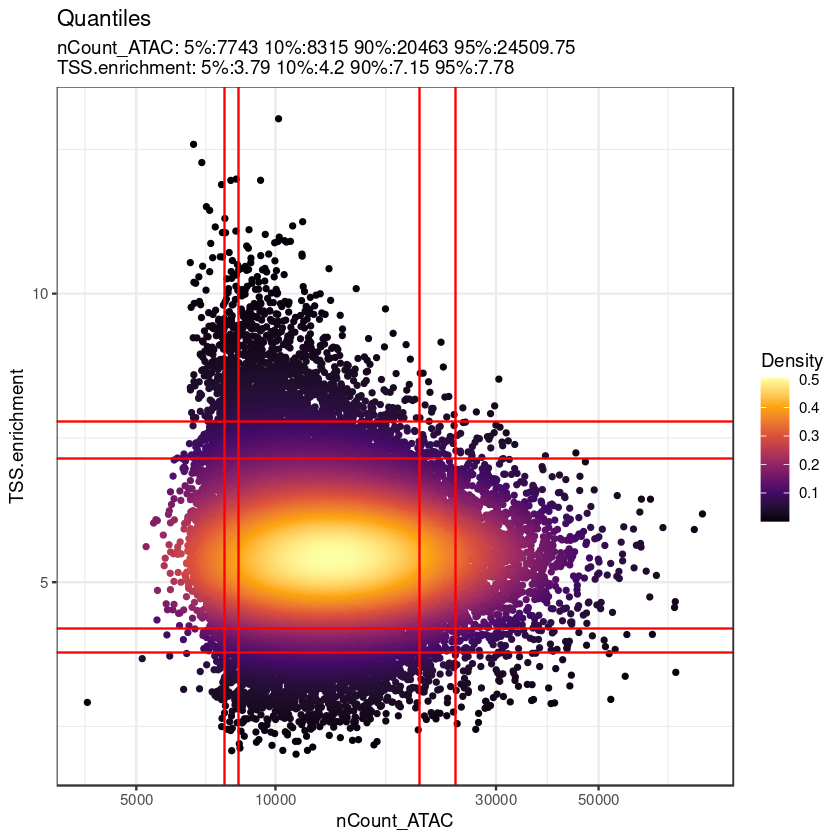

In [9]:
DensityScatter(seurat_obj, x = 'nCount_ATAC', y = 'TSS.enrichment', log_x = TRUE, quantiles = TRUE)

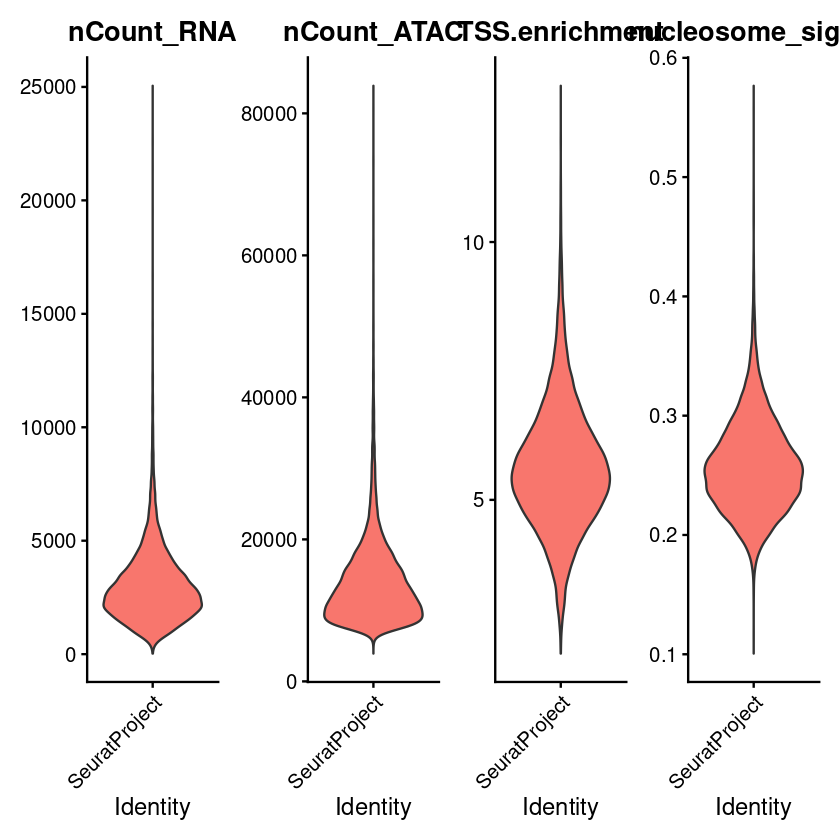

In [10]:
VlnPlot(
  object = seurat_obj,
  features = c("nCount_RNA", "nCount_ATAC", "TSS.enrichment", "nucleosome_signal"),
  ncol = 4,
  pt.size = 0
)

In [11]:
seurat_obj <- subset(seurat_obj, 
                     subset = nCount_ATAC > 8315 & nCount_ATAC < 25000 & 
                              TSS.enrichment > 0.75 & 
                              nCount_RNA > 1000 & 
                              nucleosome_signal < 0.3)


In [12]:
##Gene expression data processing
DefaultAssay(seurat_obj) <- "RNA"
seurat_obj <- NormalizeData(seurat_obj, normalization.method = "LogNormalize", verbose = FALSE)
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)
seurat_obj <- ScaleData(seurat_obj, verbose = FALSE)
seurat_obj <- RunPCA(seurat_obj, verbose = FALSE)


Finding variable features for layer counts



In [13]:
##DNA accessibility data processing
DefaultAssay(seurat_obj) <- "ATAC"
seurat_obj <- FindTopFeatures(seurat_obj, min.cutoff = 5)
seurat_obj <- RunTFIDF(seurat_obj)
seurat_obj <- RunSVD(seurat_obj)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



In [14]:
seurat_obj <- FindMultiModalNeighbors(seurat_obj, reduction.list = list("pca", "lsi"), dims.list = list(1:50, 2:50))
seurat_obj <- RunUMAP(seurat_obj, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
seurat_obj <- FindClusters(seurat_obj, graph.name = "wsnn", algorithm = 3, verbose = FALSE)

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
00:01:42 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

00:01:44 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 20

00:01:48 Initializing from normalized Laplacian + noise (using RSpectra)

00:01:49 Commencing optimization for 200 epochs, with 677760 positive edges

00:02:18 Optimization finished



In [15]:
reference <- readRDS("reference_cellxgene.rds")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



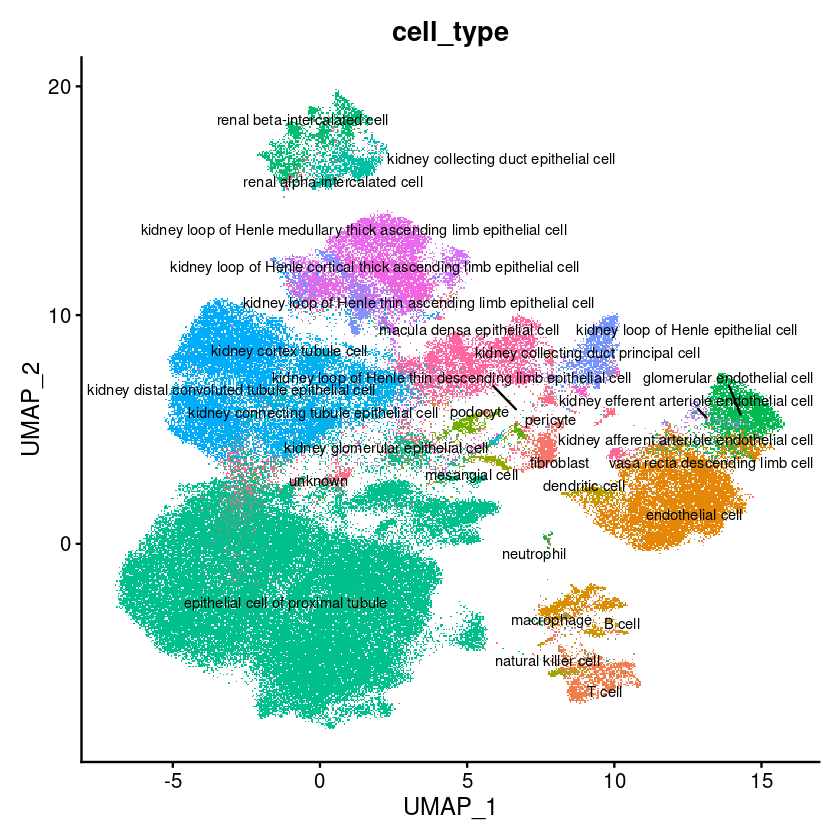

In [16]:
DimPlot(object = reference, reduction = "umap", group.by = "cell_type", label = TRUE, label.size = 3, repel = TRUE) + NoLegend()

In [17]:
# reference_cell_type <- reference$cell_type

reference <- UpdateSeuratObject(reference)

# reference$cell_type <- reference_cell_type

colnames(reference@meta.data)


Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Updating matrix keys for DimReduc 'scANVI'

Updating matrix keys for DimReduc 'scVI'

Updating matrix keys for DimReduc 'umap'

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Updating slots in RNA

Updating slots in scANVI

Updating slots in scVI

Updating slots in umap

Setting umap DimReduc to global

Validating object structure for Assay 'RNA'

Validating object structure for DimReduc 'scANVI'

Validating object structure for DimReduc 'scVI'

Validating object structure for DimReduc 'umap'

Object representation is consistent with the most current Seurat version



[1] "Origin"                                  
 [2] "suspension_type"                         
 [3] "nFeaturess_RNA"                          
 [4] "nFeaturess_RNA_by_counts"                
 [5] "log1p_nFeaturess_RNA_by_counts"          
 [6] "total_counts"                            
 [7] "log1p_total_counts"                      
 [8] "total_counts_mt"                         
 [9] "log1p_total_counts_mt"                   
[10] "pct_counts_mt"                           
[11] "total_counts_ribo"                       
[12] "log1p_total_counts_ribo"                 
[13] "pct_counts_ribo"                         
[14] "total_counts_hb"                         
[15] "log1p_total_counts_hb"                   
[16] "pct_counts_hb"                           
[17] "author_cell_type"                        
[18] "disease_ontology_term_id"                
[19] "self_reported_ethnicity_ontology_term_id"
[20] "cell_type_ontology_term_id"              
[21] "organism_ontology_term_id"               
[22] "sex_ontology_term_id"                    
[23] "is_primary_data"                         
[24] "development_stage_ontology_term_id"      
[25] "tissue_ontology_term_id"                 
[26] "assay_ontology_term_id"                  
[27] "donor_id"                                
[28] "tissue_type"                             
[29] "cell_type"                               
[30] "assay"                                   
[31] "disease"                                 
[32] "organism"                                
[33] "sex"                                     
[34] "tissue"                                  
[35] "self_reported_ethnicity"                 
[36] "development_stage"                       
[37] "observation_joinid"                      
[38] "nCount_RNA"                              
[39] "nFeature_RNA"

In [18]:
DefaultAssay(seurat_obj) <- "RNA"


In [19]:
head(rownames(seurat_obj))

[1] "ENSMUSG00000051951" "ENSMUSG00000089699" "ENSMUSG00000102331"
[4] "ENSMUSG00000102343" "ENSMUSG00000025900" "ENSMUSG00000025902"

In [20]:
DefaultAssay(reference) <- "RNA"
reference <- FindVariableFeatures(reference, selection.method = "vst", nfeatures = 2000)
reference <- ScaleData(reference, verbose = FALSE)
reference <- RunPCA(reference, npcs=50)

PC_ 1 
Positive:  ENSMUSG00000079018, ENSMUSG00000060802, ENSMUSG00000025492, ENSMUSG00000054690, ENSMUSG00000026921, ENSMUSG00000027800, ENSMUSG00000022587, ENSMUSG00000002504, ENSMUSG00000020077, ENSMUSG00000032766 
	   ENSMUSG00000007872, ENSMUSG00000026814, ENSMUSG00000073411, ENSMUSG00000062960, ENSMUSG00000056313, ENSMUSG00000018593, ENSMUSG00000004951, ENSMUSG00000047867, ENSMUSG00000006356, ENSMUSG00000034845 
	   ENSMUSG00000060591, ENSMUSG00000054435, ENSMUSG00000027210, ENSMUSG00000001240, ENSMUSG00000026185, ENSMUSG00000062515, ENSMUSG00000029648, ENSMUSG00000016494, ENSMUSG00000022661, ENSMUSG00000031871 
Negative:  ENSMUSG00000021699, ENSMUSG00000026610, ENSMUSG00000055737, ENSMUSG00000038679, ENSMUSG00000071669, ENSMUSG00000060579, ENSMUSG00000035472, ENSMUSG00000028399, ENSMUSG00000027070, ENSMUSG00000055373 
	   ENSMUSG00000052942, ENSMUSG00000047454, ENSMUSG00000026748, ENSMUSG00000022708, ENSMUSG00000109532, ENSMUSG00000063458, ENSMUSG00000070867, ENSMUSG00000061731,

In [21]:
reference_features <- rownames(reference)
query_features <- rownames(seurat_obj)
length(intersect(reference_features, query_features)) 

[1] 15497

In [22]:
anchors <- FindTransferAnchors(
  reference = reference,
  query = seurat_obj,
  normalization.method = "LogNormalize",
  reference.reduction = "pca",
  dims = 1:50
)

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 5684 anchors



In [23]:
seurat_obj <- TransferData(
  anchorset = anchors,
  reference = reference,
  query = seurat_obj,
  refdata = list(cell_type = "cell_type")  # confirm this exists with colnames(reference@meta.data)
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
"Layer counts isn't present in the assay object; returning NULL"


In [24]:
seurat_obj <- IntegrateEmbeddings(
  anchorset = anchors,
  reference = reference,
  query = seurat_obj,
  new.reduction.name = "ref.pca"
)

Warning message:
"Layer counts isn't present in the assay object; returning NULL"
Warning message:
"Layer counts isn't present in the assay object; returning NULL"

Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data



In [25]:
reference <- RunUMAP(
  object = reference,
  reduction = "pca",          # or "spca" or "wnn" depending on your case
  dims = 1:50,
  return.model = TRUE         # <-- critical for ProjectUMAP!
)


UMAP will return its model

00:08:27 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

00:08:27 Read 141401 rows and found 50 numeric columns

00:08:27 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by 'spam'

00:08:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:08:44 Writing NN index file to temp file /tmp/RtmpgXKRmn/file13316b4f6

00:08:44 Searching Annoy index using 1 thread, search_k = 3000

00:09:30 Annoy recall = 100%

00:09:34 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

00:09:42 Initializing fr

In [26]:
seurat_obj <- ProjectUMAP(
  query = seurat_obj,
  query.reduction = "ref.pca",
  reference = reference,
  reference.reduction = "pca",
  reduction.model = "umap"  # or "wnn.umap" if using WNN integration
)


Computing nearest neighbors

Running UMAP projection

00:13:44 Read 21726 rows

00:13:44 Processing block 1 of 1

00:13:44 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

00:13:45 Initializing by weighted average of neighbor coordinates using 1 thread

00:13:45 Commencing optimization for 67 epochs, with 651780 positive edges

00:13:54 Finished



In [27]:
colnames(seurat_obj@meta.data)


[1] "orig.ident"                "nCount_RNA"               
 [3] "nFeature_RNA"              "nCount_ATAC"              
 [5] "nFeature_ATAC"             "nucleosome_signal"        
 [7] "nucleosome_percentile"     "TSS.enrichment"           
 [9] "TSS.percentile"            "RNA.weight"               
[11] "ATAC.weight"               "wsnn_res.0.8"             
[13] "seurat_clusters"           "predicted.cell_type.score"
[15] "predicted.cell_type"

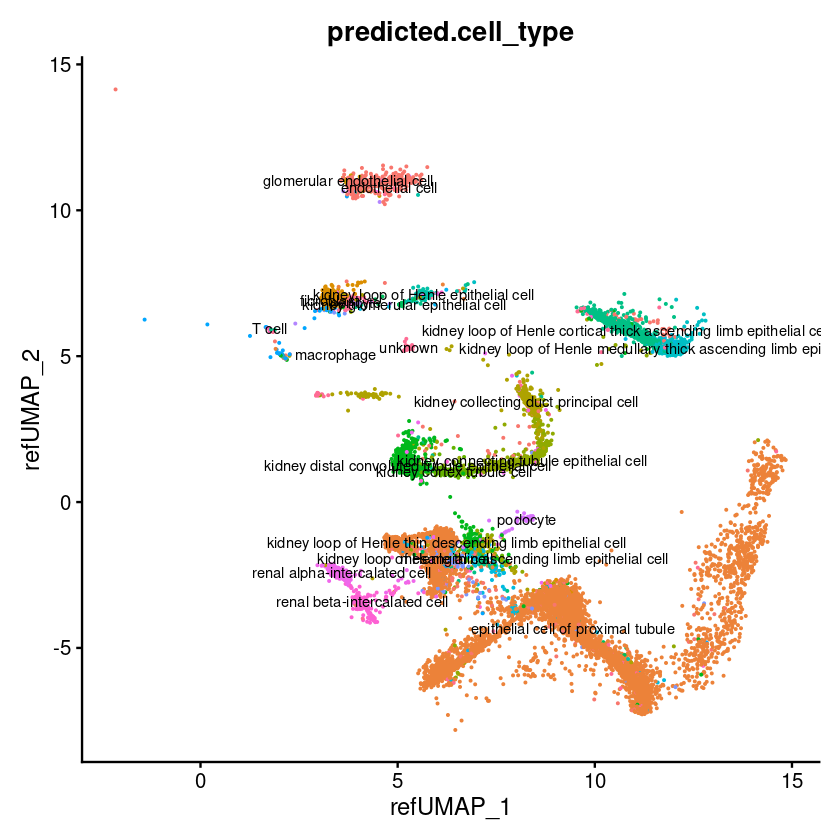

In [28]:
DimPlot(seurat_obj, 
        reduction = "ref.umap", 
        group.by = "predicted.cell_type", 
        label = TRUE, 
        label.size = 3) + NoLegend()


In [29]:
# H_genes= e2h[rownames(seurat_obj@assays$RNA@features)]
# rownames(seurat_obj@assays$RNA@features) = H_genes
# str(H_genes)

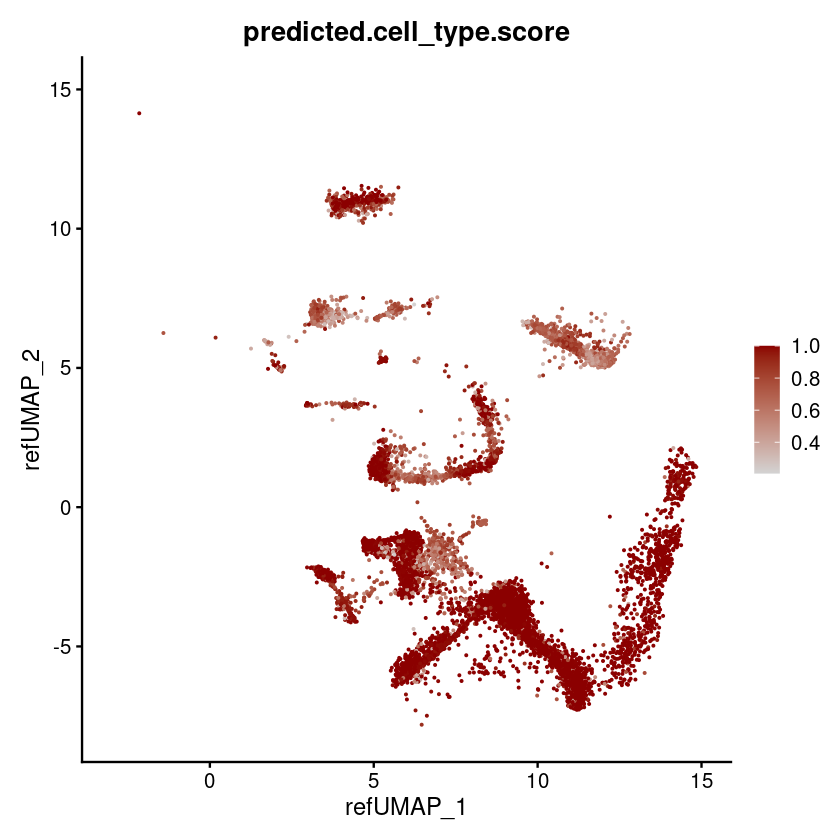

In [30]:
FeaturePlot(
  seurat_obj,
  features = "predicted.cell_type.score",
  reduction = "ref.umap",
  cols = c("lightgrey", "darkred")
)

Warning message:
"Could not find podocyte in the default search locations, found in 'prediction.score.cell_type' assay instead"
Warning message:
"Could not find macrophage in the default search locations, found in 'prediction.score.cell_type' assay instead"
Warning message:
"Could not find T cell in the default search locations, found in 'prediction.score.cell_type' assay instead"


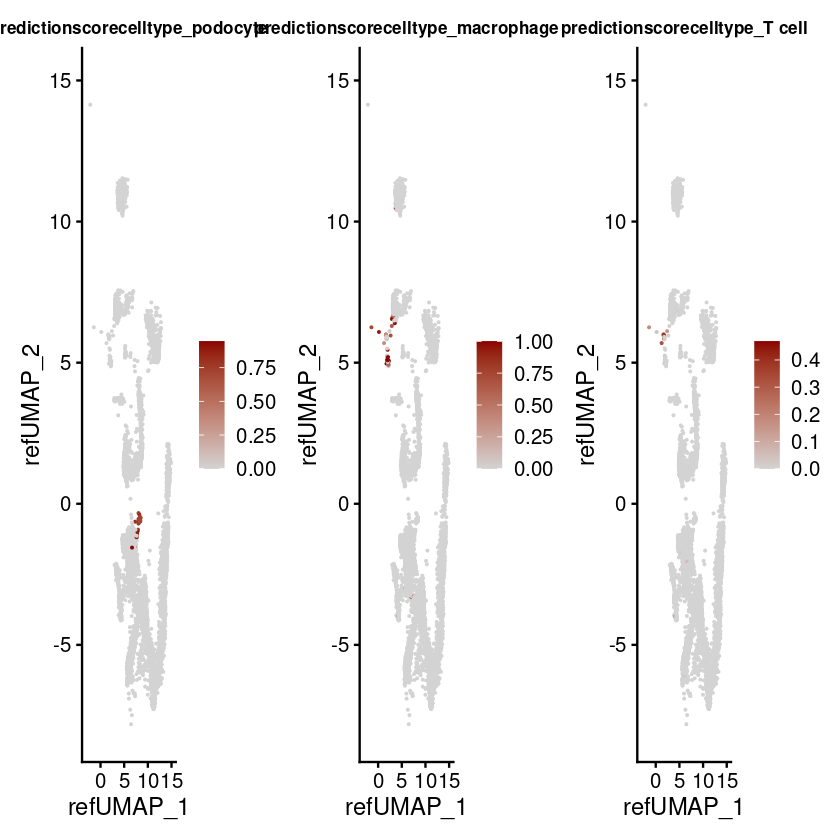

In [31]:
FeaturePlot(seurat_obj, features = c("podocyte", "macrophage", "T cell"),  reduction = "ref.umap", cols = c("lightgrey", "darkred"), ncol = 3) & theme(plot.title = element_text(size = 10))

In [32]:
H_genes <- e2h[rownames(seurat_obj)]
rownames(seurat_obj) <- H_genes
head(rownames(seurat_obj))


Warning message:
"Renaming features in v3/v4 assays is not supported"


[1] "Xkr4"    "Gm1992"  "Gm19938" "Gm37381" "Rp1"     "Sox17"

In [33]:
s_id = c('PFKO_7','PFKO_8','PFWT_5','PFWT_6','PMKO_3','PMKO_4','PMWT_1','PMWT_2')
table(s_id[as.integer(substr(colnames(seurat_obj),18,18))] )
seurat_obj@meta.data$sample=s_id[as.integer(substr(colnames(seurat_obj),18,18))]
# Define the knockout samples
knockout_samples <- c('PFKO_7', 'PFKO_8', 'PMKO_3', 'PMKO_4')

# Add the 'identity' column to the Seurat object metadata
seurat_obj@meta.data$identity <- ifelse(seurat_obj@meta.data$sample %in% knockout_samples, 'KO', 'WT')

# Define the samples that are male and female
male_samples <- c('PMKO_3', 'PMKO_4', 'PMWT_1', 'PMWT_2')  # Replace with actual male sample IDs
female_samples <- c('PFKO_7', 'PFKO_8', 'PFWT_5', 'PFWT_6')  # Replace with actual female sample IDs

# Add the sex column to the metadata
seurat_obj@meta.data$sex <- ifelse(seurat_obj@meta.data$sample %in% male_samples, 'male', 'female')


PFKO_7 PFKO_8 PFWT_5 PFWT_6 PMKO_3 PMKO_4 PMWT_1 PMWT_2 
  3430   3200   2408   3539   2440   2646   1705   2358 

In [34]:
nrow(macro_markers)
nrow(podo_markers)


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'nrow': object 'macro_markers' not found


In [35]:
Idents(seurat_obj) <- "predicted.cell_type"
podo_markers <- FindMarkers(
  seurat_obj,
  ident.1 = "podocyte",
  only.pos = TRUE,
  logfc.threshold = 0.1,
  test.use = "LR"  # or "MAST"
)
head(podo_markers)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Magi2,4.548613e-220,5.494781,1.000,0.636,1.366631e-215
Ptpro,5.509744e-213,10.586828,0.975,0.006,1.655403e-208
Nebl,4.689886e-192,9.858806,0.963,0.005,1.409076e-187
Wt1,8.409791e-182,10.163778,0.901,0.003,2.526722e-177
Nphs1,1.198487e-179,10.320661,0.901,0.002,3.600855e-175
Podxl,1.308492e-179,7.502875,1.000,0.025,3.931363e-175


In [36]:
PD_markers <- FindMarkers(
  seurat_obj,
  ident.1 = "podocyte",
  only.pos = TRUE,
  logfc.threshold = 0.1,
  test.use = "MAST"  
)
head(PD_markers)


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Magi2,5.396743e-316,5.494781,1.000,0.636,1.621451e-311
Ptpro,1.098356e-227,10.586828,0.975,0.006,3.300011e-223
Pard3b,1.205994e-214,3.775108,0.988,0.611,3.623409e-210
Dpp4,1.301932e-196,4.041977,0.988,0.289,3.911655e-192
Nebl,2.798610e-194,9.858806,0.963,0.005,8.408424e-190
Podxl,1.626862e-190,7.502875,1.000,0.025,4.887908e-186


In [37]:
write.csv(PD_markers, file = "PD_markers_podocytes.csv")
write.csv(podo_markers, file = "podo_markers_podocytes.csv")


In [57]:
head(top_podo)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,8.067412e-16,12.63656,0.074,0.000,2.423854e-11,Gm11636
2,8.067412e-16,12.61151,0.074,0.000,2.423854e-11,Nxph3
3,7.875552e-11,11.48535,0.049,0.000,2.366210e-06,Mrgprf
4,2.952376e-136,11.38577,0.691,0.001,8.870414e-132,Myom2
5,6.014918e-16,10.77504,0.086,0.000,1.807182e-11,Tmem54
6,3.004265e-67,10.70643,0.370,0.001,9.026316e-63,Gabra4


In [58]:
# Filter DEGs with significant adjusted p-value
top_podo <- PD_markers[PD_markers$p_val_adj < 0.05, ]

# Sort by adjusted p-value
top_podo <- top_podo[order(top_podo$p_val_adj), ]

# Add gene names as a column (if needed)
top_podo$gene <- rownames(top_podo)

# View top genes
head(top_podo, 10)


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Magi2,5.396743e-316,5.494781,1.000,0.636,1.621451e-311,Magi2
Ptpro,1.098356e-227,10.586828,0.975,0.006,3.300011e-223,Ptpro
Pard3b,1.205994e-214,3.775108,0.988,0.611,3.623409e-210,Pard3b
Dpp4,1.301932e-196,4.041977,0.988,0.289,3.911655e-192,Dpp4
Nebl,2.798610e-194,9.858806,0.963,0.005,8.408424e-190,Nebl
Podxl,1.626862e-190,7.502875,1.000,0.025,4.887908e-186,Podxl
Zfp385b,2.517417e-189,4.944310,0.975,0.150,7.563580e-185,Zfp385b
Srgap1,1.130986e-188,7.439947,1.000,0.026,3.398046e-184,Srgap1
Man1a2,8.883376e-187,3.896598,0.963,0.288,2.669010e-182,Man1a2


In [40]:
podocytes <- subset(seurat_obj, idents = "podocyte")

Warning message in DoHeatmap(podocytes, features = top_genes, group.by = "identity", :
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: Man1a2"


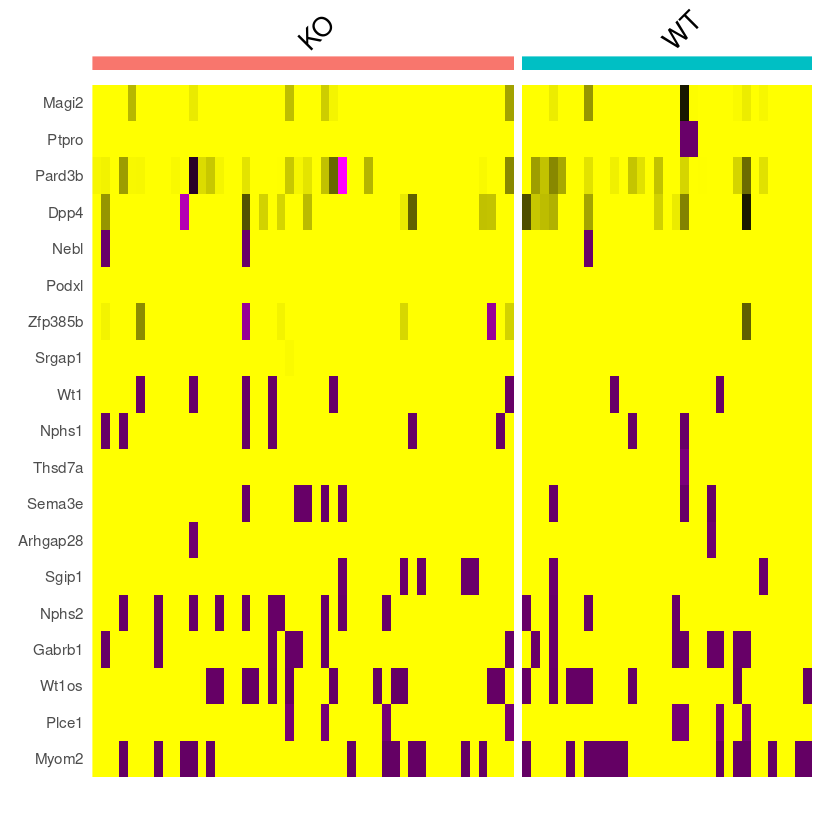

In [108]:
top_genes <- rownames(top_podo)[1:20]  # or more if you want a broader panel
Idents(podocytes) <- "identity"
DoHeatmap(
  podocytes,
  features = top_genes,
  group.by = "identity",
  assay = "RNA",     # or "SCT"
  label = TRUE
) + NoLegend()


Warning message:
"Scaling data with a low number of groups may produce misleading results"


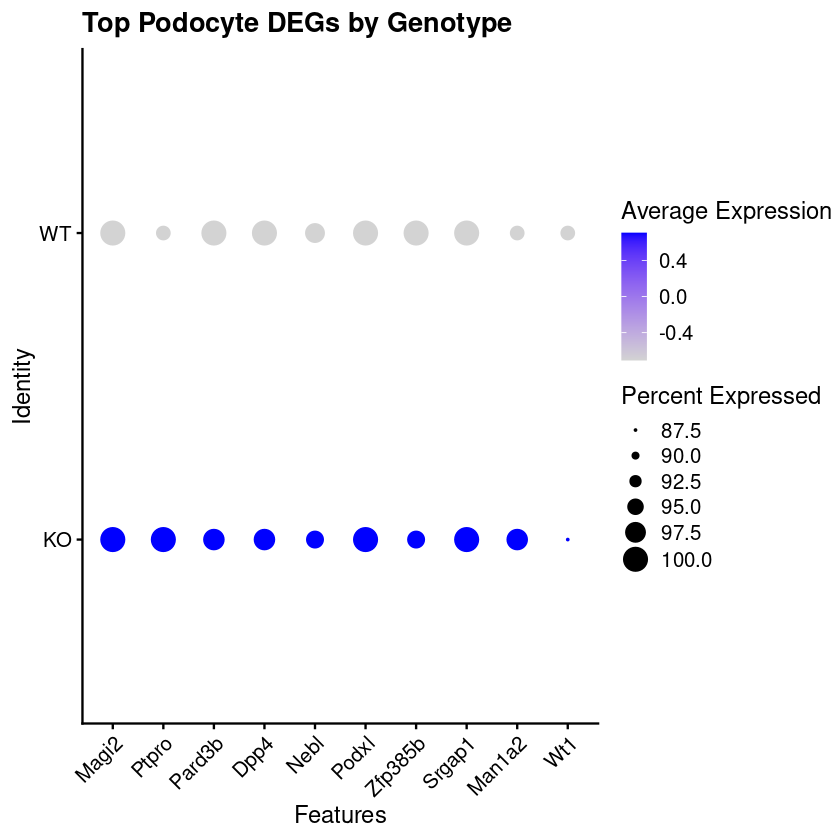

In [60]:
top_genes <- rownames(top_podo)[1:10]  # Or top 20, depending on your figure space
DotPlot(
  podocytes,
  features = top_genes,
  group.by = "identity"
) + 
  RotatedAxis() +
  labs(title = "Top Podocyte DEGs by Genotype")


In [112]:
library(dplyr)

# Upregulated genes in KO
up_genes <- PD_markers %>% 
  filter(p_val_adj < 0.05 & avg_log2FC > 0.25) %>% 
  pull(gene)

# Downregulated genes in KO
down_genes <- PD_markers %>% 
  filter(p_val_adj < 0.05 & avg_log2FC < -0.25) %>% 
  pull(gene)

# Convert gene symbols to Entrez IDs
up_entrez <- bitr(up_genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Mm.eg.db)
down_entrez <- bitr(down_genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Mm.eg.db)



Attaching package: 'dplyr'


The following objects are masked from 'package:ensembldb':

    filter, select


The following object is masked from 'package:AnnotationDbi':

    select


The following object is masked from 'package:Biobase':

    combine


The following objects are masked from 'package:Biostrings':

    collapse, intersect, setdiff, setequal, union


The following object is masked from 'package:XVector':

    slice


The following objects are masked from 'package:GenomicRanges':

    intersect, setdiff, union


The following object is masked from 'package:GenomeInfoDb':

    intersect


The following objects are masked from 'package:IRanges':

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from 'package:S4Vectors':

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':



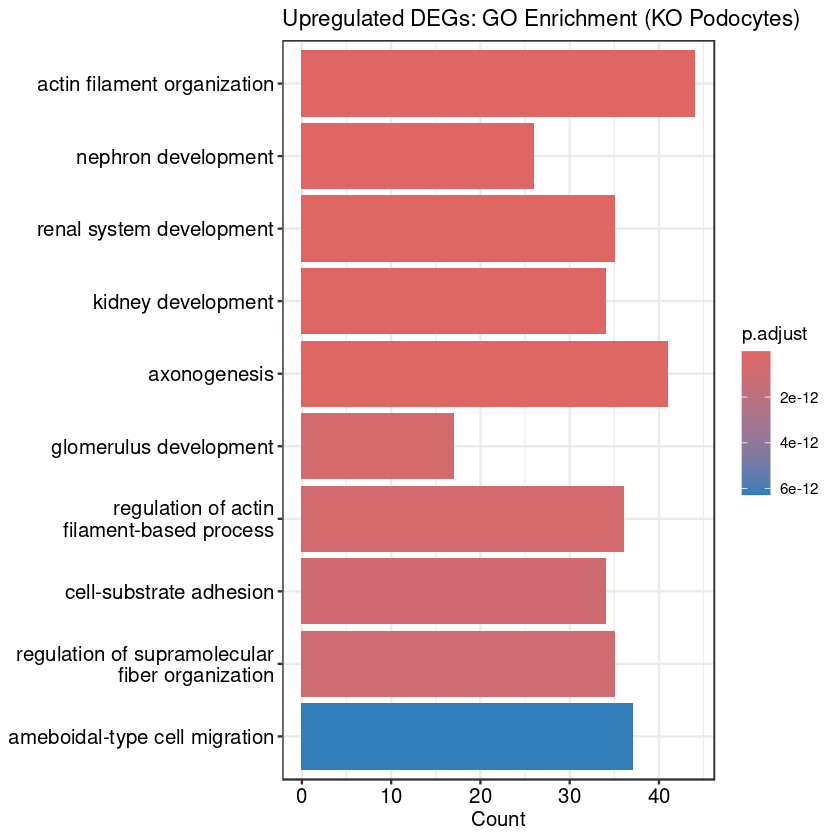

In [117]:
go_up <- enrichGO(gene = up_entrez$ENTREZID,
                  OrgDb = org.Mm.eg.db,
                  ont = "BP", # Biological Process
                  pAdjustMethod = "BH",
                  pvalueCutoff = 0.05,
                  readable = TRUE)
barplot(go_up, showCategory = 10, title = "Upregulated DEGs: GO Enrichment (KO Podocytes)")

In [61]:
# install.packages("BiocManager")
# BiocManager::install(c("clusterProfiler", "org.Mm.eg.db"))

# library(clusterProfiler)
# library(org.Mm.eg.db)
# Extract gene symbols
gene_symbols <- rownames(top_podo)

# Convert to Entrez IDs
gene_ids <- bitr(gene_symbols, 
                 fromType = "SYMBOL",
                 toType = "ENTREZID",
                 OrgDb = org.Mm.eg.db)


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_symbols, fromType = "SYMBOL", toType = "ENTREZID", :
"2.11% of input gene IDs are fail to map..."


,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0007015,GO:0007015,actin filament organization,44/488,454/28564,1.532373e-20,6.445159e-17,4.592279e-17,Nebl/Nphs1/Arhgap28/Synpo/Tmod3/Iqgap2/Tjp1/Kirrel/Sema5a/Elmo1/Myo1d/Myo1e/Shroom3/Tmsb4x/Plekhh2/Kank1/Itgb5/Cald1/Arhgef18/Nck2/Fchsd2/Cd2ap/Coro2b/Sdc4/Dlc1/Fat1/Pak1/Gas7/Tpm1/Rhpn1/Gsn/Pls3/Mtss1/Sirpa/Myh9/Hsp90b1/Prkce/Tmsb10/Hip1/Actn4/Wasl/Sptb/Arpc2/Shroom2,44
GO:0072006,GO:0072006,nephron development,26/488,162/28564,5.626784e-18,1.183313e-14,8.431292e-15,Ptpro/Wt1/Plce1/Enpep/Vegfa/Sulf1/Myo1e/Il6ra/Hs3st3a1/Npnt/Col4a4/Itga3/Foxd1/Tcf21/Col4a3/Foxc2/Foxc1/Mtss1/Lamb2/Eya1/Lama5/Actn4/Ctnnd1/Bmp7/Gpc3/Smo,26
GO:0072001,GO:0072001,renal system development,35/488,352/28564,6.517260e-17,9.137198e-14,6.510399e-14,Ptpro/Wt1/Plce1/Enpep/Robo2/Vegfa/Cdkn1c/Sulf1/Myo1e/Il6ra/Hs3st3a1/Npnt/Col4a4/Itga3/Foxd1/Tcf21/Col4a3/Rhpn1/Nek1/Foxc2/Foxc1/Mtss1/Lamb2/Fgfr1/Tns2/Stat1/Ptk7/Schip1/Eya1/Lama5/Actn4/Ctnnd1/Bmp7/Gpc3/Smo,35
GO:0001822,GO:0001822,kidney development,34/488,336/28564,1.074553e-16,9.394739e-14,6.693901e-14,Ptpro/Wt1/Plce1/Enpep/Robo2/Vegfa/Cdkn1c/Sulf1/Myo1e/Il6ra/Hs3st3a1/Npnt/Col4a4/Itga3/Foxd1/Tcf21/Col4a3/Rhpn1/Nek1/Foxc2/Foxc1/Mtss1/Lamb2/Fgfr1/Tns2/Ptk7/Schip1/Eya1/Lama5/Actn4/Ctnnd1/Bmp7/Gpc3/Smo,34
GO:0007409,GO:0007409,axonogenesis,41/488,498/28564,1.116826e-16,9.394739e-14,6.693901e-14,Ptpro/Sema3e/Robo2/Vegfa/Ntrk3/Sema3g/Ephb1/Prkg1/Alcam/Sema5a/Adcy1/Mapt/Flrt2/Ntng2/Gas1/Efnb1/Aplp1/Itgb1/Dag1/Foxd1/Vim/Epha6/Pak1/Unc5c/Megf9/Bmpr1b/Dpysl2/App/Ust/Lamb2/Ncam1/Lama5/Gbx1/Stxbp1/Lrtm2/Cdkl5/Bmp7/Actb/Smo/Auts2/Plxnb1,41
GO:0032835,GO:0032835,glomerulus development,17/488,67/28564,1.049006e-15,7.353531e-13,5.239508e-13,Ptpro/Wt1/Plce1/Enpep/Sulf1/Myo1e/Il6ra/Col4a4/Tcf21/Col4a3/Foxc2/Foxc1/Mtss1/Lamb2/Actn4/Ctnnd1/Bmp7,17


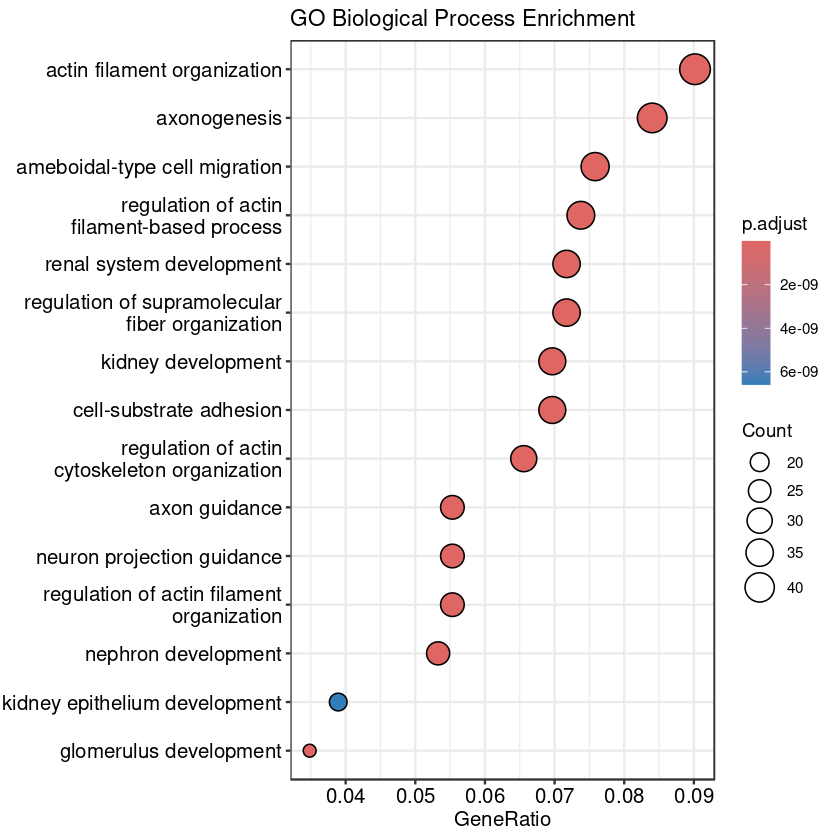

In [62]:
go_results <- enrichGO(
  gene          = gene_ids$ENTREZID,
  OrgDb         = org.Mm.eg.db,
  ont           = "BP",  # Biological Process
  pAdjustMethod = "BH",
  pvalueCutoff  = 0.05,
  qvalueCutoff  = 0.2,
  readable      = TRUE
)
# View table
head(go_results)

# Dotplot
dotplot(go_results, showCategory = 15) + ggtitle("GO Biological Process Enrichment")


In [64]:
GO= barplot(go_results, showCategory = 15) + ggtitle("GO Biological Process Enrichment")
ggsave("GO.png", plot = GO, width = 12, height = 6, dpi = 300)

In [28]:
DefaultAssay(seurat_obj) <- "ATAC"
library(Signac)
library(BSgenome.Mmusculus.UCSC.mm10)

seurat_obj <- RegionStats(
  object = seurat_obj,
  genome = BSgenome.Mmusculus.UCSC.mm10
)

Warning message in RegionStats.default(object = regions, genome = genome, verbose = verbose, :
"Not all seqlevels present in supplied genome"


In [ ]:
DefaultAssay(seurat_obj) <- 'ATAC'

seurat_obj <- FindTopFeatures(seurat_obj, min.cutoff = 10)
seurat_obj <- RunTFIDF(seurat_obj)
seurat_obj <- RunSVD(seurat_obj)
seurat_obj <- RunUMAP(seurat_obj, reduction = 'lsi', dims = 2:30, reduction.name = 'umap.atac')
p1 <- DimPlot(seurat_obj, label = TRUE) + NoLegend() + ggtitle("RNA UMAP")
p2 <- DimPlot(seurat_obj, reduction = 'umap.atac', label = TRUE) + NoLegend() + ggtitle("ATAC UMAP")
p1 + p2

  theme(legend.position = "right")  # Legend on the right side

# Save in wide format (good for split plots)
ggsave("UMAP_wide.png", plot = umap_plot, width = 12, height = 6, dpi = 300)

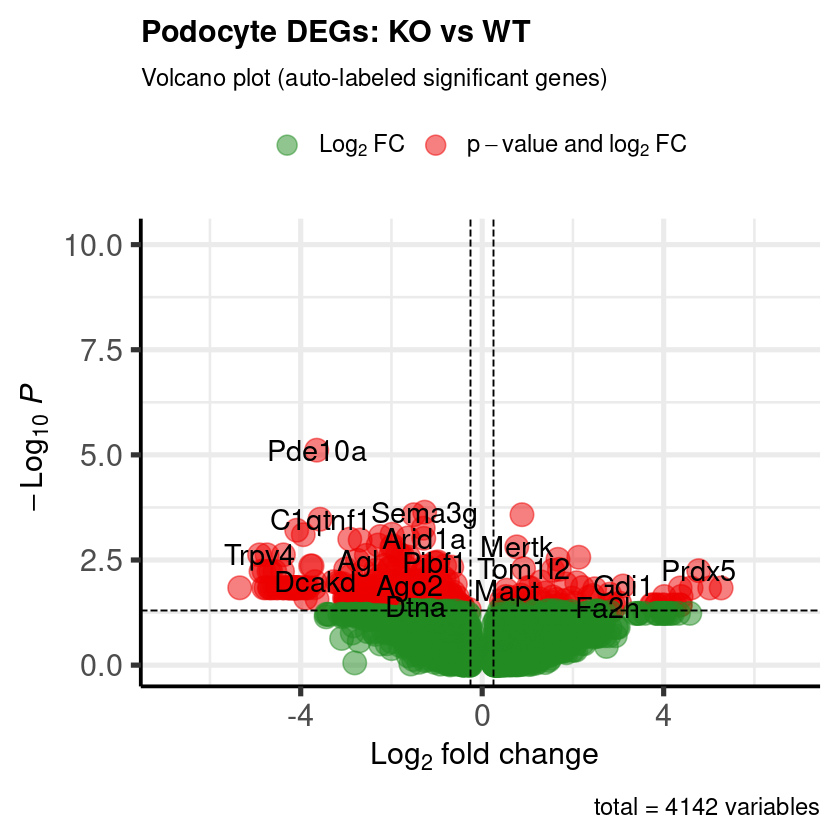

In [74]:
library(EnhancedVolcano)

# Define cutoffs
p_cutoff <- 0.05
log2fc_cutoff <- 0.25

# Create a label column: only label genes that pass both thresholds
deg_podo$label <- ifelse(
  deg_podo$p_val < p_cutoff & abs(deg_podo$avg_log2FC) > log2fc_cutoff,
  deg_podo$gene,
  NA
)

# Plot
VP <- EnhancedVolcano(
  deg_podo,
  lab = deg_podo$label,       # Now only significant genes get labels
  x = 'avg_log2FC',
  y = 'p_val',                # If you want adjusted, use 'p_val_adj'
  pCutoff = p_cutoff,
  FCcutoff = log2fc_cutoff,
  title = 'Podocyte DEGs: KO vs WT',
  subtitle = 'Volcano plot (auto-labeled significant genes)',
  pointSize = 6.0,
  labSize = 6.0
)
VP
ggsave("VP_deg.png", plot = VP, width = 16, height = 10, dpi = 300)

In [65]:
# Set your p-value threshold
p_thresh <- 0.05

# Add gene names as a column (if they are rownames)
PD_markers$gene <- rownames(PD_markers)

# Upregulated genes (positive log2FC + significant adjusted p-value)
up_genes <- PD_markers[
  PD_markers$p_val_adj < p_thresh & PD_markers$avg_log2FC > 0, 
]

# Downregulated genes (negative log2FC + significant adjusted p-value)
down_genes <- PD_markers[
  PD_markers$p_val_adj < p_thresh & PD_markers$avg_log2FC < 0, 
]

# Sort both by significance (adjusted p-value)
up_genes <- up_genes[order(up_genes$p_val_adj), ]
down_genes <- down_genes[order(down_genes$p_val_adj), ]

# View top results
head(up_genes, 5)
head(down_genes, 5)


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Magi2,5.396743e-316,5.494781,1.000,0.636,1.621451e-311,Magi2
Ptpro,1.098356e-227,10.586828,0.975,0.006,3.300011e-223,Ptpro
Pard3b,1.205994e-214,3.775108,0.988,0.611,3.623409e-210,Pard3b
Dpp4,1.301932e-196,4.041977,0.988,0.289,3.911655e-192,Dpp4
Nebl,2.798610e-194,9.858806,0.963,0.005,8.408424e-190,Nebl


p_val,avg_log2FC,pct.1,pct.2,p_val_adj,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>


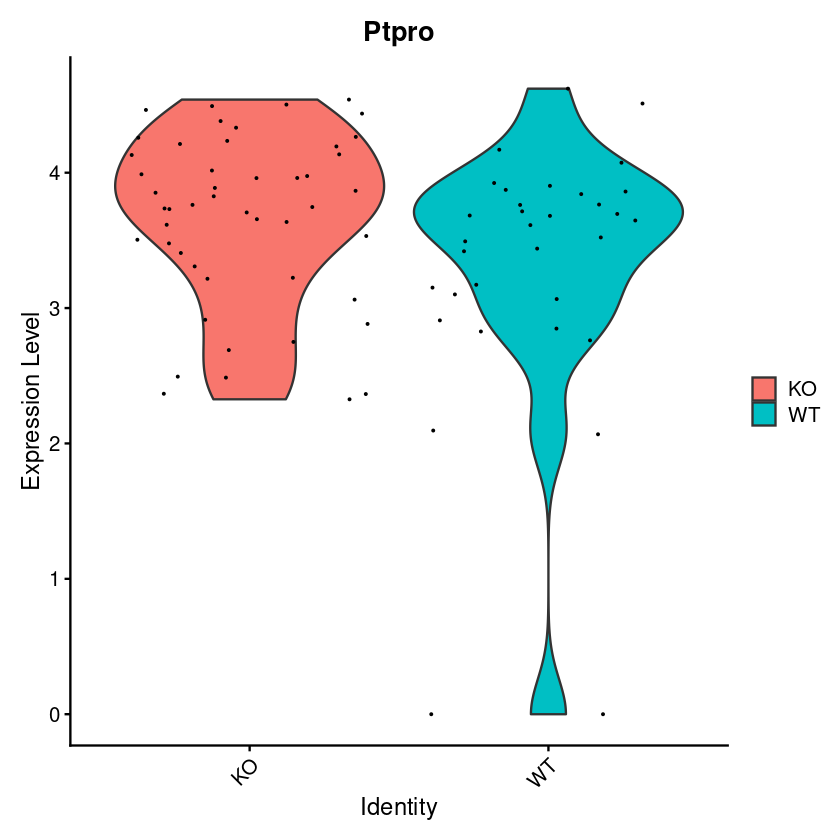

In [95]:
# Compare average expression of a top gene
VlnPlot(podocytes, features = "Ptpro", group.by = "identity", assay = "RNA")


In [105]:
VP= VlnPlot(podocytes, features = top10_genes, group.by = "identity", pt.size = 0.05)
ggsave("Vln_deg.png", plot = VP, width = 16, height = 10, dpi = 300)

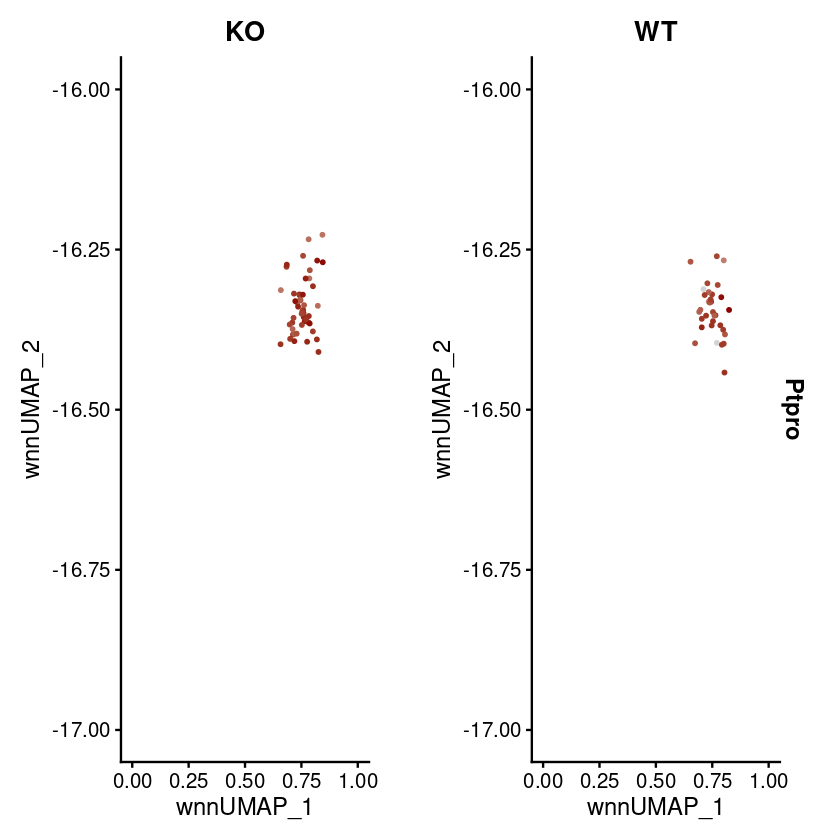

In [103]:
FeaturePlot(
  object = podocytes,
  features = "Ptpro",
  split.by = "identity",        # ✅ this is the correct arg
  reduction = "wnn.umap",       # or "umap" if appropriate
  cols = c("lightgrey", "darkred"),
  pt.size = 0.6
)


Warning message:
"Removed 148 rows containing missing values or values outside the scale range
(`geom_segment()`)."


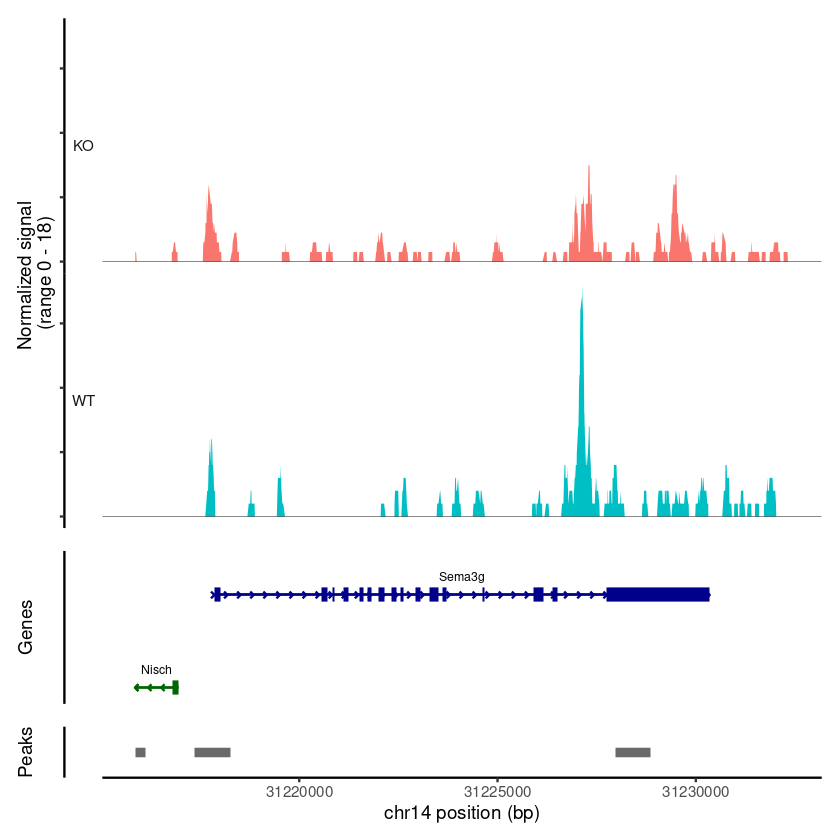

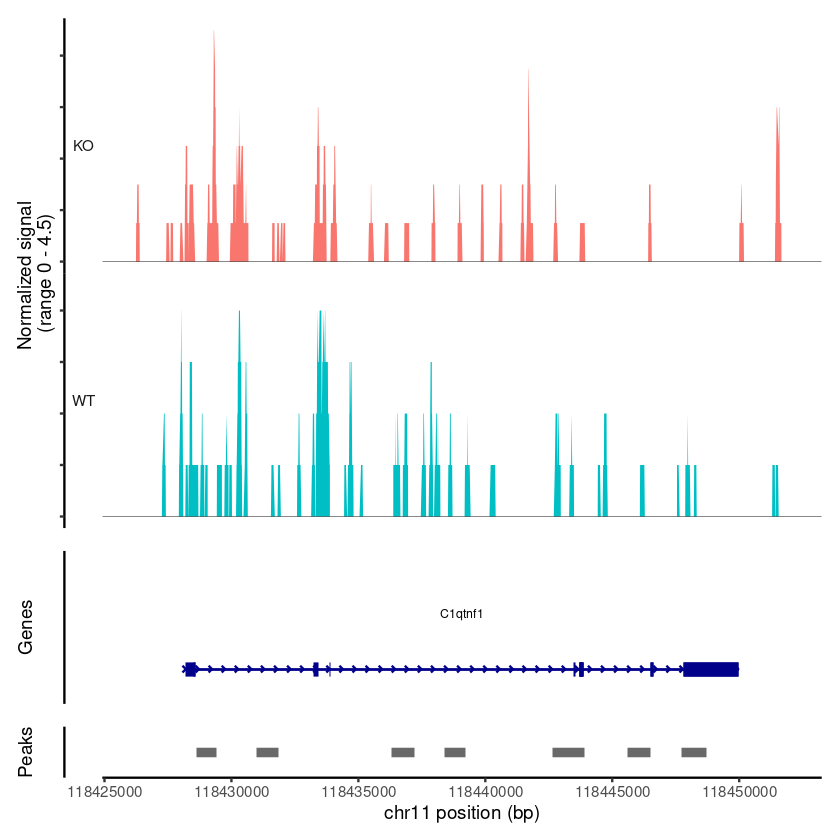

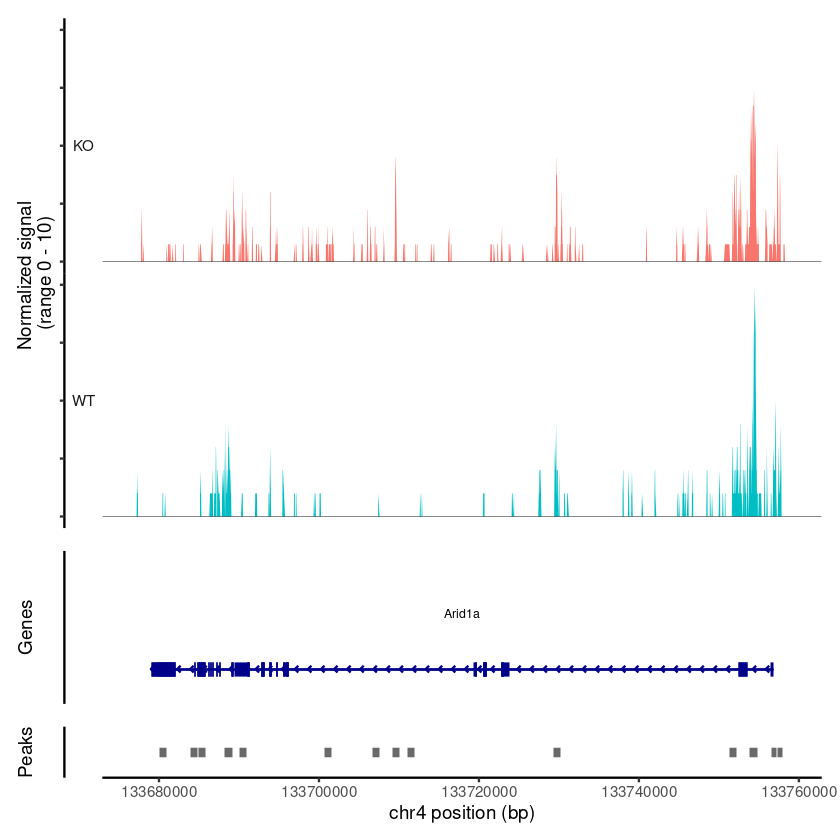

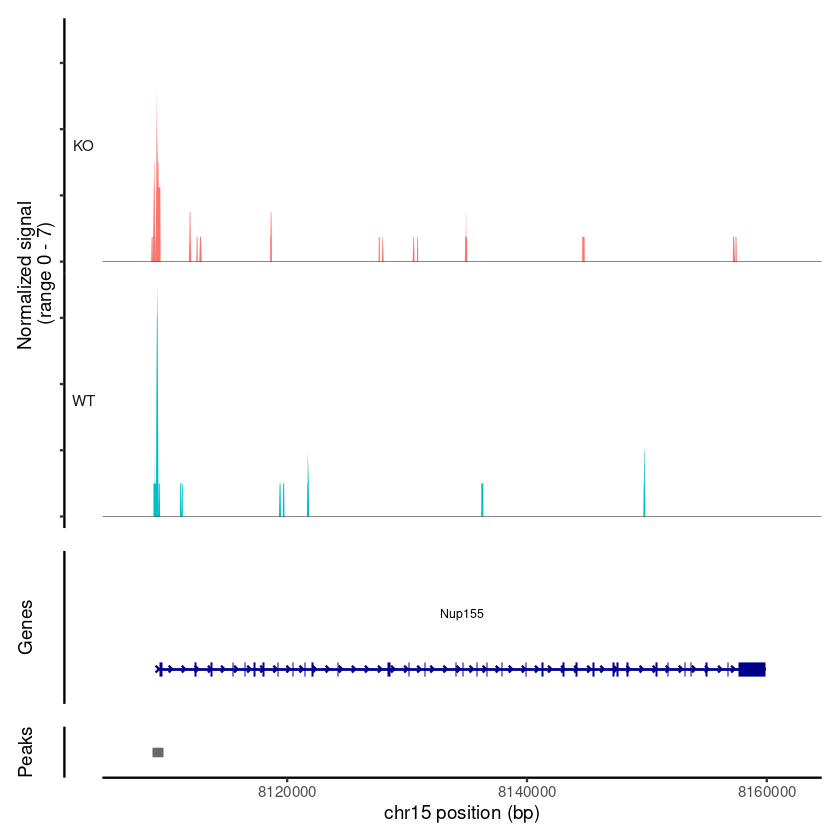

In [127]:
genes_of_interest <- c("Sema3g", "C1qtnf1", "Arid1a", "Nup155")

for (gene in genes_of_interest) {
  print(CoveragePlot(
    object = podocytes,
    region = gene,
    group.by = "identity",
    annotation = TRUE,
    peaks = TRUE,
    extend.upstream = 2000,
    extend.downstream = 2000
  ))
}


Warning message:
"Removed 97 rows containing missing values or values outside the scale range
(`geom_segment()`)."


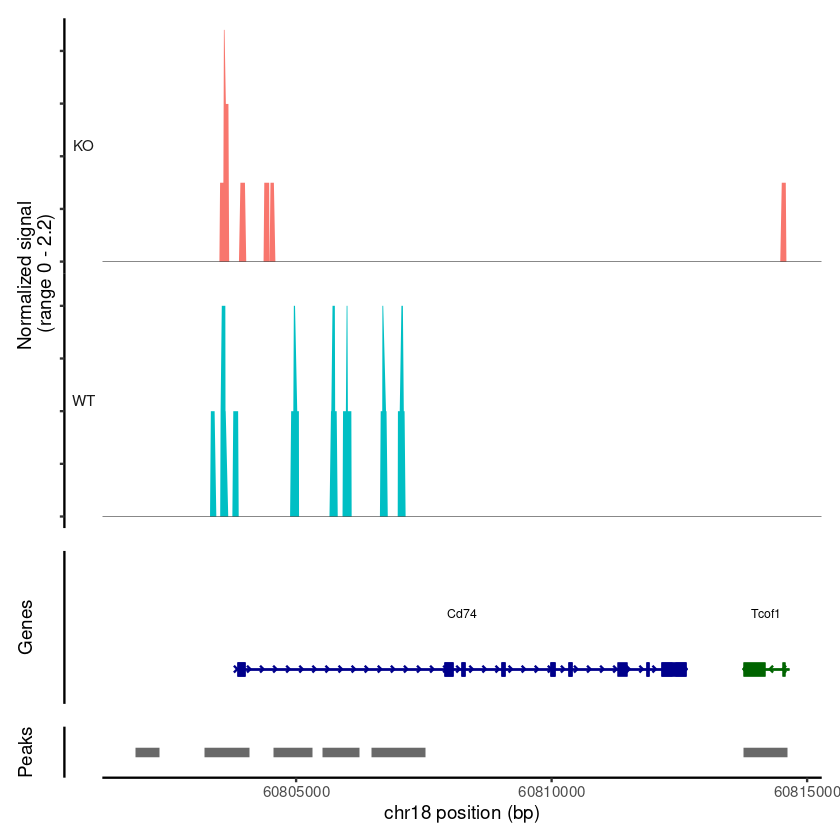

In [135]:
DefaultAssay(podocytes) <- "ATAC"
CoveragePlot(
  object = podocytes,
  region = "Cd74",
  group.by = "identity",
  annotation = TRUE,
  peaks = TRUE,
  extend.upstream = 2000,
  extend.downstream = 2000
)


In [148]:
motif_df <- read.csv("enriched.motifs.csv")  # adjust path as needed
head(motif_df)


,X,motif,observed,background,percent.observed,percent.background,fold.enrichment,pvalue,motif.name,p.adjust
,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,MA1684.1,MA1684.1,114,7121,40.56940,17.8025,2.278859,2.737097e-19,Foxn1,2.928694e-17
2,MA0146.2,MA0146.2,131,9979,46.61922,24.9475,1.868693,2.508817e-15,Zfx,1.342217e-13
3,MA0007.3,MA0007.3,56,2937,19.92883,7.3425,2.714174,6.580543e-12,Ar,2.347060e-10
4,MA0742.1,MA0742.1,95,7869,33.80783,19.6725,1.718532,1.642506e-08,Klf12,4.393704e-07
5,MA0006.1,MA0006.1,84,8141,29.89324,20.3525,1.468775,9.099850e-05,Ahr::Arnt,1.947368e-03
6,MA1615.1,MA1615.1,97,9974,34.51957,24.9350,1.384382,1.995613e-04,Plagl1,3.558844e-03


In [151]:
library(Signac)
library(JASPAR2020)
library(TFBSTools)

# Add motif info
pfm <- getMatrixSet(JASPAR2020, opts = list(species = 10090, all_versions = FALSE))
podocytes <- AddMotifs(object = podocytes, genome = BSgenome.Mmusculus.UCSC.mm10, pfm = pfm)


Building motif matrix

Warning message in CreateMotifMatrix(features = object, pwm = pfm, genome = genome, :
"Not all seqlevels present in supplied genome"
Warning message in .merge_two_Seqinfo_objects(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrM, chr1_GL455991_alt, chr1_GL455992_alt, chr1_GL455993_alt, chr1_GL456005_alt, chr1_JH584315_alt, chr1_JH584320_alt, chr1_JH584321_alt, chr1_JH584322_alt, chr2_GL456024_alt, chr3_GL456006_alt, chr3_GL456007_alt, chr3_GL456008_alt, chr3_GL456042_alt, chr3_GL456044_alt, chr3_GL456045_alt, chr3_GL456048_alt, chr3_GL456049_alt, chr3_JH584323_alt, chr4_GL455994_alt, chr4_GL456009_alt, chr4_GL456010_alt, chr4_GL456053_alt, chr4_GL456064_alt, chr4_GL456075_alt, chr4_GL456076_alt, chr4_GL456077_alt, chr4_JH584268_alt, chr4_JH584269_alt, chr4_JH584324_alt, chr4_JH584325_alt, chr4_JH584326_alt, chr5_GL455995_alt, chr5_GL456011_alt, chr6_GL456012_alt, chr6_GL456025_alt, chr6_GL456026_alt, chr6_GL456054_alt, 

In [156]:
Idents(podocytes) <- podocytes$identity  # Or whatever column holds KO/WT
da_peaks <- FindMarkers(
  object = podocytes,
  ident.1 = 'KO',
  ident.2 = 'WT',
  only.pos = TRUE,
  test.use = 'LR',
  min.pct = 0.05,
  latent.vars = 'nCount_ATAC'
)

# get top differentially accessible peaks
top.da.peak <- rownames(da_peaks[da_peaks$p_val < 0.005 & da_peaks$pct.1 > 0.2, ])

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

In [157]:
# test enrichment
enriched.motifs <- FindMotifs(
  object = podocytes,
  features = top.da.peak
)

Selecting background regions to match input sequence characteristics

Matching GC.percent distribution

Testing motif enrichment in 42 regions



Warning message:
"The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the ggseqlogo package.
  Please report the issue at <https://github.com/omarwagih/ggseqlogo/issues>."


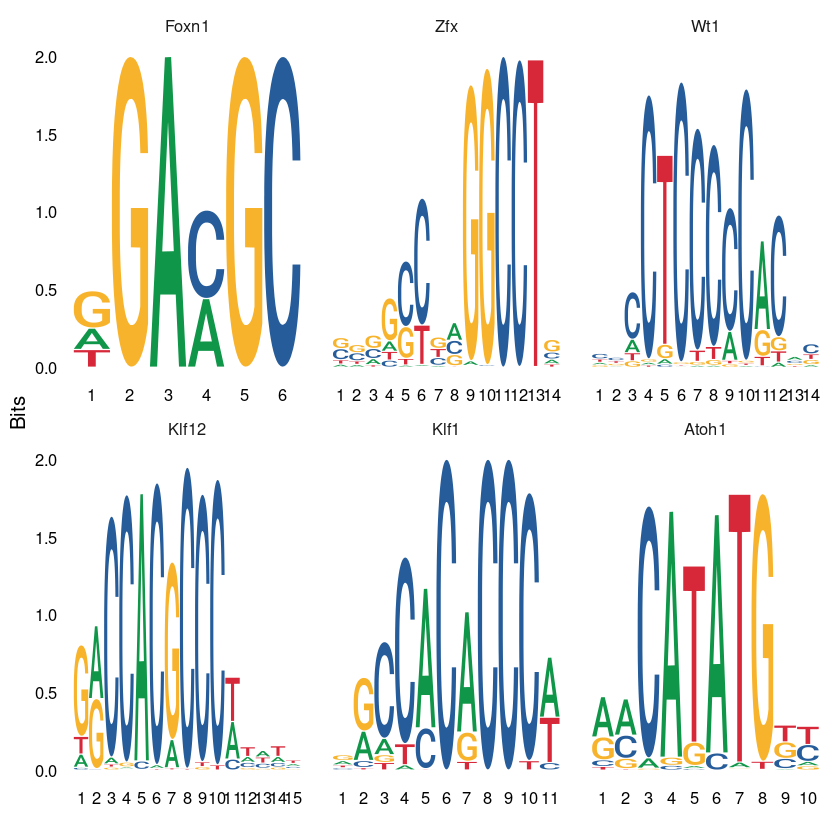

In [158]:
MotifPlot(
  object = podocytes,
  motifs = head(rownames(enriched.motifs))
)

In [160]:
head(enriched.motifs)

,motif,observed,background,percent.observed,percent.background,fold.enrichment,pvalue,motif.name,p.adjust
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
MA1684.1,MA1684.1,20,7037,47.61905,17.5925,2.706781,7.411519e-06,Foxn1,0.000504017
MA0146.2,MA0146.2,23,9263,54.76190,23.1575,2.364759,9.420879e-06,Zfx,0.000504017
MA1627.1,MA1627.1,26,16631,61.90476,41.5775,1.488901,6.248342e-03,Wt1,0.177186727
MA0742.1,MA0742.1,15,7441,35.71429,18.6025,1.919865,6.623803e-03,Klf12,0.177186727
MA0493.1,MA0493.1,19,11219,45.23810,28.0475,1.612910,1.286415e-02,Klf1,0.275292867
MA0461.2,MA0461.2,4,1234,9.52381,3.0850,3.087134,3.992973e-02,Atoh1,0.712080273


In [172]:
head(da_peaks)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr15-89078095-89079036,4.020338e-05,11.422530,0.188,0.000,1
chr17-12915850-12916754,6.787284e-05,1.752550,0.521,0.212,1
chr17-84511467-84512327,1.461751e-04,3.819882,0.333,0.030,1
chr11-82845536-82846345,1.529962e-04,12.873338,0.250,0.000,1
chr12-21111213-21112103,2.652634e-04,2.261262,0.417,0.091,1
chr17-29436943-29437763,2.966207e-04,3.719196,0.312,0.030,1


In [174]:
# Upreg/downreg peaks in KO podocytes
up_ko <- rownames(da_peaks[da_peaks$avg_log2FC > 1, ])

down_ko <- rownames(da_peaks[da_peaks$avg_log2FC < -1, ])
closest_genes_up <- ClosestFeature(podocytes, regions = up_ko)
closest_genes_down <- ClosestFeature(podocytes, regions = down_ko)

head(closest_genes_up)
head(closest_genes_down)


Warning message in ClosestFeature(podocytes, regions = up_ko):
"The following seqlevels present in query regions are not present
 in the supplied gene annotations and will be removed: JH584304.1"


ERROR: Error in .Call2("C_find_overlaps_in_groups_NCList", start(q), end(q), : build_NCList: memory allocation failed


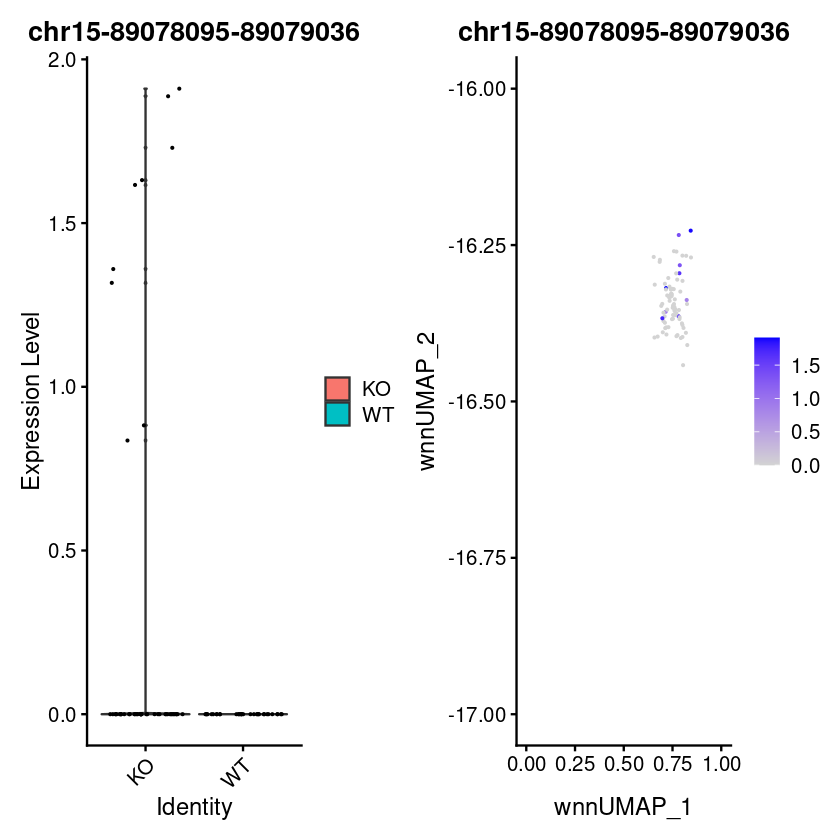

In [173]:
plot1 <- VlnPlot(
  object = podocytes,
  features = rownames(da_peaks)[1],
  pt.size = 0.1,
  idents = podocytes$identity
)
plot2 <- FeaturePlot(
  object = podocytes,
  features = rownames(da_peaks)[1],
  pt.size = 0.1
)

plot1 | plot2